In [5]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from modelling_functions import *
from DengueModel import *

import datetime

import warnings
warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Data

In [6]:
# Import the dataset
data = pd.read_csv('../datasets/data_features_with_lags.csv')

In [7]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [8]:
# Check the shape of the data
data.shape

(257, 35)

In [9]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            257 non-null    object 
 1   dengue_cases                    257 non-null    int64  
 2   denv_1                          257 non-null    float64
 3   denv_2                          257 non-null    float64
 4   denv_3                          257 non-null    float64
 5   denv_4                          257 non-null    float64
 6   Mean Temperature (°C)           257 non-null    float64
 7   Mean Wind Speed (km/h)          257 non-null    float64
 8   Daily Rainfall Total (mm)       257 non-null    float64
 9   Maximum Temperature (°C)        257 non-null    float64
 10  Max Wind Speed (km/h)           257 non-null    float64
 11  Minimum Temperature (°C)        257 non-null    float64
 12  google_trends                   257 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [10]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [11]:
# Set the time as the index
data = data.set_index('time')

In [12]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [13]:
data.drop(columns=['denv_1', 'denv_2', 'denv_3', 'denv_4'], inplace=True)

In [14]:
# create a 1-week lag dengue cases variable for prediction
data['dengue_cases_lag_1'] = data['dengue_cases'].shift(1)
data['dengue_cases_lag_2'] = data['dengue_cases'].shift(2)
data['dengue_cases_lag_3'] = data['dengue_cases'].shift(3)

In [15]:
data.drop(columns=['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
                  'month_12'], inplace=True)

In [16]:
data.drop(columns=['Mean Wind Speed (km/h)', 'Maximum Temperature (°C)', 'Max Wind Speed (km/h)', 'Minimum Temperature (°C)'], inplace=True)

In [17]:
# keep 2023 data as the unseen dataset for final testing
data_subset = data.loc[data.index.year < 2023, :]

In [18]:
# Lag predictors by 1 week to produce 1-week ahead forecast
columns_to_shift = list(data_subset.columns)
columns_to_shift.remove('dengue_cases')

data_subset[columns_to_shift] = data_subset[columns_to_shift].shift(1)

In [19]:
# drop any remaining NA values
data_subset.dropna(inplace=True)

In [20]:
train, test = train_test_split(data_subset, year=2021)

In [2]:
model_16wk_lookahead = pickle.load(open('../models/model_16wk_lookahead.sav', 'rb'))

In [27]:
data.loc[[get_date_index(1,2023)], :]

,dengue_cases,Mean Temperature (°C),Daily Rainfall Total (mm),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,dengue_cases_lag_1,dengue_cases_lag_2,dengue_cases_lag_3
time,,,,,,,,,,,,,,,,,,
2023-01-01,279,27.1,2.285714,27,27.9,27.428571,6.771429,9.785714,11.314286,33.0,33.0,42.6,38.9,24.1,0.690386,285.0,272.0,289.0


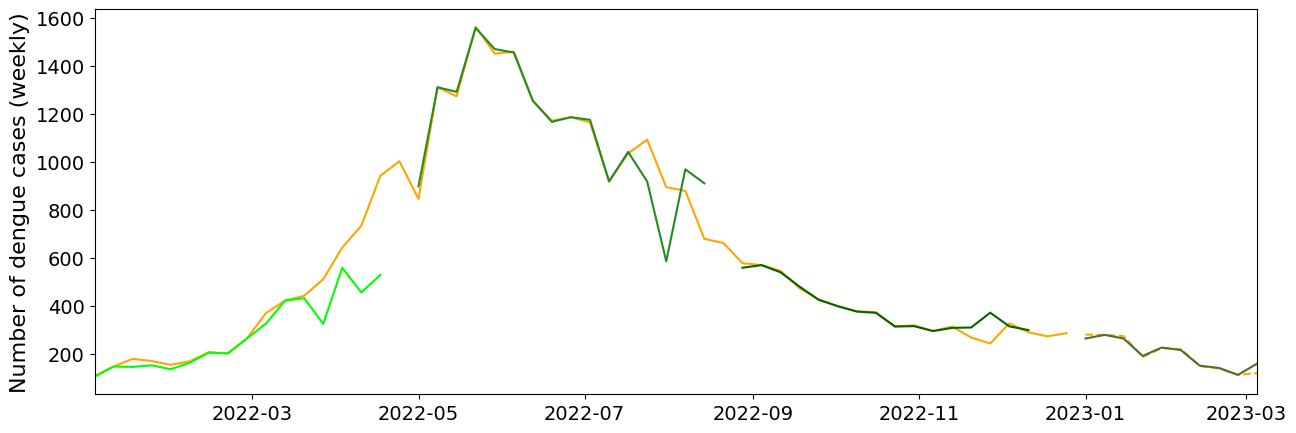

In [33]:
# plotting predictions on validation dataset for presentation

plt.figure(figsize=(15, 5))    
plt.plot(data.loc[data.index.year==2022, ['dengue_cases']], c='orange')

# try week 52 of 2021
start_point_data = data.loc[[get_date_index(52, 2021)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='lime')

# try week 17 of 2022
start_point_data = data.loc[[get_date_index(17, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='forestgreen')

# try week 34 of 2022
start_point_data = data.loc[[get_date_index(34, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkgreen')

# put in 2023 data
plt.plot(data.loc[data.index.year==2023, ['dengue_cases']], c='orange', linestyle='--')

# try week 52 of 2022
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkolivegreen')

plt.ylabel('Number of dengue cases (weekly)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(test.index[0], data.index[-1])

plt.show()

In [34]:
model_52wk_lookahead = pickle.load(open('../models/model_52wk_lookahead.sav', 'rb'))

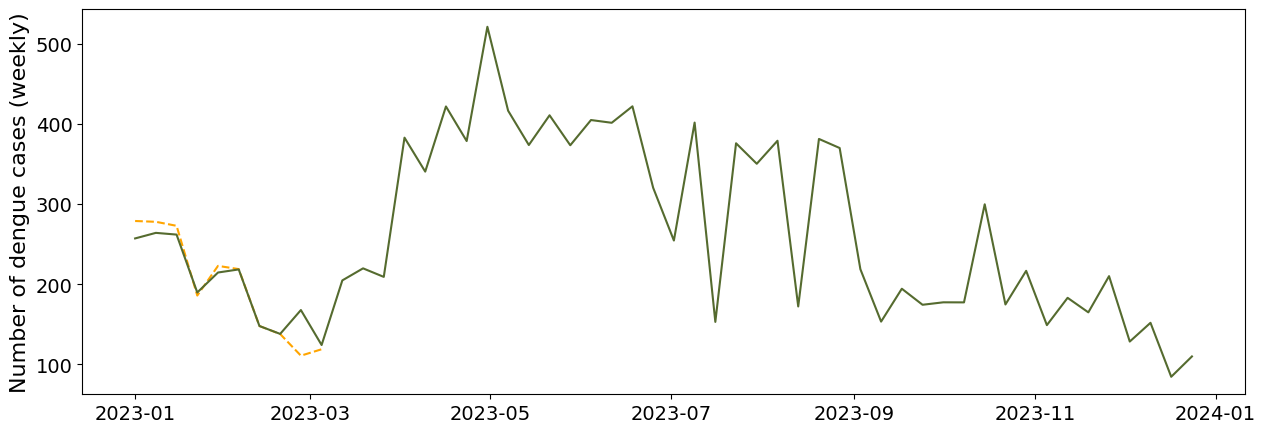

In [36]:
# plotting predictions on test dataset for presentation

plt.figure(figsize=(15, 5))    

# put in 2023 data
plt.plot(data.loc[data.index.year==2023, ['dengue_cases']], c='orange', linestyle='--')

# try week 52 of 2022
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_52wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_52wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkolivegreen')

plt.ylabel('Number of dengue cases (weekly)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()